In [2]:
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --upgrade tensorflow-cpu chdb pandas pyarrow scikit-learn numpy matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import zipfile
import urllib.request
import os
import chdb
from chdb import session

# Download and extract the dataset
if not os.path.exists("ml-25m/ratings.csv"):
    url = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    filehandle, _ = urllib.request.urlretrieve(url)
    zip_file_object = zipfile.ZipFile(filehandle, "r")
    zip_file_object.extractall()

!ls -l ml-25m

total 1129584
-rw-r--r-- 1 root root     10460 Dec 11 08:24 README.txt
-rw-r--r-- 1 root root 435164157 Dec 11 08:24 genome-scores.csv
-rw-r--r-- 1 root root     18103 Dec 11 08:24 genome-tags.csv
-rw-r--r-- 1 root root   1368578 Dec 11 08:24 links.csv
-rw-r--r-- 1 root root   3038099 Dec 11 08:24 movies.csv
-rw-r--r-- 1 root root 678260987 Dec 11 08:24 ratings.csv
-rw-r--r-- 1 root root  38810332 Dec 11 08:24 tags.csv


In [4]:
# Peek at the data
print(chdb.query("SELECT * FROM file('ml-25m/ratings.csv') LIMIT 5"))

1,296,5,1147880044
1,306,3.5,1147868817
1,307,5,1147868828
1,665,5,1147878820
1,899,3.5,1147868510



## Create views for the tables of movieLens dataset

In [5]:
# Create tables for the tables of movieLens dataset
chs = session.Session()
chs.query("CREATE DATABASE IF NOT EXISTS movielens ENGINE = Atomic")
chs.query("USE movielens")
chs.query(
    "CREATE VIEW movies AS SELECT movieId, title, genres FROM file('ml-25m/movies.csv')"
)
chs.query(
    "CREATE VIEW ratings AS SELECT userId, movieId, rating, timestamp FROM file('ml-25m/ratings.csv')"
)
chs.query(
    "CREATE VIEW tags AS SELECT userId, movieId, tag, timestamp FROM file('ml-25m/tags.csv')"
)
print(chs.query("SELECT * FROM movies LIMIT 5", "CSVWithNames"))
print(chs.query("SELECT * FROM ratings LIMIT 5", "CSVWithNames"))
print(chs.query("SELECT * FROM tags LIMIT 5", "CSVWithNames"))

"movieId","title","genres"
1,"Toy Story (1995)","Adventure|Animation|Children|Comedy|Fantasy"
2,"Jumanji (1995)","Adventure|Children|Fantasy"
3,"Grumpier Old Men (1995)","Comedy|Romance"
4,"Waiting to Exhale (1995)","Comedy|Drama|Romance"
5,"Father of the Bride Part II (1995)","Comedy"

"userId","movieId","rating","timestamp"
1,296,5,1147880044
1,306,3.5,1147868817
1,307,5,1147868828
1,665,5,1147878820
1,899,3.5,1147868510

"userId","movieId","tag","timestamp"
3,260,"classic",1439472355
3,260,"sci-fi",1439472256
4,1732,"dark comedy",1573943598
4,1732,"great dialogue",1573943604
4,7569,"so bad it's good",1573943455



## Create a view to join the movies/ratings

In [6]:
# Create a view to join the movies/ratings, if user rating >3.5 to a movie then 1(like) else 0(dislike)
chs.query(
    """
    CREATE OR REPLACE VIEW user_ratings AS
        SELECT ratings.userId userId, ratings.movieId movieId, movies.title title, genres,
            CASE WHEN rating > 3.5 THEN 1 ELSE 0 END AS liked
        FROM ratings
        JOIN movies USING movieId
    """
)
# Peek at the data
print(chs.query("SELECT * FROM user_ratings LIMIT 5", "CSVWithNames"))

# Split the data into train and test with userId
chs.query(
    """
    CREATE OR REPLACE VIEW train AS
        SELECT userId, movieId, title, genres, liked
        FROM user_ratings
        WHERE userId % 10 < 8;
    CREATE OR REPLACE VIEW test AS
        SELECT userId, movieId, title, genres, liked
        FROM user_ratings
        WHERE userId % 10 >= 8;
    """
)
# Count the number of rows in train and test
print("Training rows:", chs.query("SELECT COUNT(*) FROM train"))
print("Test rows:", chs.query("SELECT COUNT(*) FROM test"))

"userId","movieId","title","genres","liked"
1,296,"Pulp Fiction (1994)","Comedy|Crime|Drama|Thriller",1
1,306,"Three Colors: Red (Trois couleurs: Rouge) (1994)","Drama",0
1,307,"Three Colors: Blue (Trois couleurs: Bleu) (1993)","Drama",1
1,665,"Underground (1995)","Comedy|Drama|War",1
1,899,"Singin' in the Rain (1952)","Comedy|Musical|Romance",0

Training rows: 19994500

Test rows: 5005595



## Train a DNN model to predict if a user will like a movie or not

In [7]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Load the data
train_data = chs.query(
    "SELECT userId, movieId, title, genres, liked FROM train", "DataFrame"
)
validate_data = chs.query(
    "SELECT userId, movieId, title, genres, liked FROM test", "DataFrame"
)

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1]
X_val = validate_data.values[:, :-1]
y_val = validate_data.values[:, -1]

print("X_train sample:", X_train[0])
print("y_train sample:", y_train[0])
print("X_val sample:", X_val[0])
print("y_val sample:", y_val[0])

# Split the movie title to extract the shooting year as a feature
# eg. Toy Story (1995) -> 1995 if the title has no year, use 1900 instead
def get_year(title):
    try:
        return float(int(title.split("(")[-1].split(")")[0].split("-")[0]) / 2000.0)
    except:
        return 0.0
    
title_years_train = np.array(
    [get_year(title) for title in X_train[:, 2]]
)
X_train = np.concatenate((X_train, title_years_train[:, np.newaxis]), axis=1)
print("X_train sample:", X_train[0])

title_years_val = np.array(
    [get_year(title) for title in X_val[:, 2]]
)
X_val = np.concatenate((X_val, title_years_val[:, np.newaxis]), axis=1)
print("X_val sample:", X_val[0])

# Split the genres by "|" to make the genre as a sparse feature by
# one-hot encoding
genres_sparse_train = [genre.split("|") for genre in X_train[:, 3]]

# Concatenate the encoded genres with the existing features
X_train = np.concatenate((X_train, MultiLabelBinarizer().fit_transform(genres_sparse_train)), axis=1)

genres_sparse_val = [genre.split("|") for genre in X_val[:, 3]]
X_val = np.concatenate((X_val, MultiLabelBinarizer().fit_transform(genres_sparse_val)), axis=1)

# Drop the title and genres columns and keep the encoded genres, convert the data to float32
# [1 296 'Pulp Fiction (1994)' 'Comedy|Crime|Drama|Thriller' 0.997 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0]
width = X_train.shape[1]
X_train = X_train[:, np.r_[0:2, 4:width-1]].astype(np.float32)
X_val = X_val[:, np.r_[0:2, 4:width-1]].astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

print("X_train sample:", X_train[0])
print("X_val sample:", X_val[0])
# Define the model architecture
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model with log history of loss
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=40960,
    verbose=1,
)





X_train sample: [1 296 'Pulp Fiction (1994)' 'Comedy|Crime|Drama|Thriller']
y_train sample: 1
X_val sample: [8 1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy']
y_val sample: 1
X_train sample: [1 296 'Pulp Fiction (1994)' 'Comedy|Crime|Drama|Thriller' 0.997]
X_val sample: [8 1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy'
 0.9975]
X_train sample: [  1.    296.      0.997   0.      0.      0.      0.      0.      1.
   1.      0.      1.      0.      0.      0.      0.      0.      0.
   0.      0.      1.      0.   ]
X_val sample: [8.     1.     0.9975 0.     0.     1.     1.     1.     1.     0.
 0.     0.     1.     0.     0.     0.     0.     0.     0.     0.
 0.     0.    ]
Epoch 1/10
489/489 [==============================] - 6s 10ms/step - loss: 1300839.7500 - val_loss: 388.4711
Epoch 2/10
489/489 [==============================] - 4s 8ms/step - loss: 209.9686 - val_loss: 135.4464
Epoch 3/10
489/489 [==============================] - 5s 9ms/st

## Some plot of training history, and validation RMSE

123/123 [==============================] - 0s 3ms/step
RMSE: 7.247381


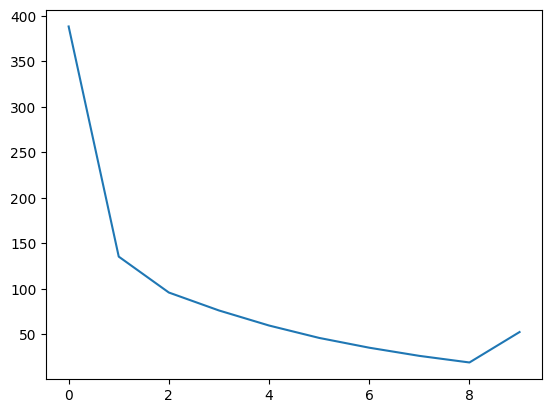

In [11]:
# Plot the loss and rmse
import matplotlib.pyplot as plt
plt.plot(history.history["val_loss"])

# Evaluate the model
y_pred = model.predict(X_val, batch_size=40960)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("RMSE:", rmse)
